In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Exploring
import scipy.stats as stats


# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import wrangle_functions
import env
import acquire
import summarize
import prepare

In [2]:
# use zillow;
# from acquire.py

acquire.get_connection('zillow')
    

def new_zillow_data():
    df = pd.read_sql('''SELECT *
    FROM properties_2017
    LEFT OUTER JOIN airconditioningtype 
    USING(airconditioningtypeid) 
    LEFT OUTER JOIN architecturalstyletype
    USING(architecturalstyletypeid) 
    LEFT OUTER JOIN buildingclasstype 
    USING(buildingclasstypeid) 
    LEFT OUTER JOIN heatingorsystemtype
    USING(heatingorsystemtypeid) 
    LEFT OUTER JOIN predictions_2017
    ON predictions_2017.id = properties_2017.id
    INNER JOIN (
    SELECT id, MAX(transactiondate) as last_trans_date 
    FROM predictions_2017
    GROUP BY id
    ) predictions ON predictions.id = properties_2017.id AND predictions_2017.transactiondate = predictions.last_trans_date
    LEFT OUTER JOIN propertylandusetype
    USING(propertylandusetypeid)
      LEFT OUTER JOIN storytype
    USING(storytypeid)
    LEFT OUTER JOIN typeconstructiontype
    USING(typeconstructiontypeid)
    JOIN unique_properties
      ON unique_properties.parcelid = properties_2017.parcelid
    WHERE latitude IS NOT NULL and longitude IS NOT NULL;''', acquire.get_connection('zillow'))
    return df

1. Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.`m

In [3]:
df = new_zillow_data()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77614 entries, 0 to 77613
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        166 non-null    float64
 1   storytypeid                   45 non-null     float64
 2   propertylandusetypeid         77614 non-null  float64
 3   heatingorsystemtypeid         48475 non-null  float64
 4   buildingclasstypeid           383 non-null    float64
 5   architecturalstyletypeid      151 non-null    float64
 6   airconditioningtypeid         21457 non-null  float64
 7   id                            77614 non-null  int64  
 8   parcelid                      77614 non-null  int64  
 9   basementsqft                  45 non-null     float64
 10  bathroomcnt                   77614 non-null  float64
 11  bedroomcnt                    77614 non-null  float64
 12  buildingqualitytypeid         50322 non-null  float64
 13  c

In [6]:
df.describe()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id,parcelid,logerror,id,parcelid
count,166.00,45.00,"77,614.00","48,475.00",383.00,151.00,"21,457.00","77,614.00","77,614.00",45.00,...,"77,614.00","76,003.00","77,103.00","1,505.00","75,519.00","77,614.00","77,614.00","77,614.00","77,614.00","77,614.00"
mean,5.99,7.00,259.94,4.04,3.78,7.43,1.93,"38,806.50","13,379,428.47",593.13,...,"2,016.00","265,047.58","5,371.52",13.91,"60,489,761,355,119.06","38,806.50","13,007,807.98",0.02,"38,806.50","13,379,428.47"
std,0.16,0.00,16.97,3.23,0.46,2.63,3.13,"22,405.38","8,351,447.64",460.92,...,0.07,"528,079.16","10,407.55",1.54,"210,075,285,376.01","22,405.38","3,518,694.35",0.17,"22,405.38","8,351,447.64"
min,4.00,7.00,31.00,1.00,1.00,2.00,1.00,0.00,"10,711,745.00",63.00,...,"2,003.00",4.00,2.54,6.00,"60,371,011,101,000.00",0.00,"10,711,855.00",-4.66,0.00,"10,711,745.00"
25%,6.00,7.00,261.00,2.00,4.00,7.00,1.00,"19,403.25","11,585,723.50",220.00,...,"2,016.00","78,406.50","2,449.60",14.00,"60,373,106,017,007.00","19,403.25","11,538,214.00",-0.02,"19,403.25","11,585,723.50"
50%,6.00,7.00,261.00,2.00,4.00,7.00,1.00,"38,806.50","12,532,247.00",540.00,...,"2,016.00","175,342.00","4,006.66",14.00,"60,375,718,002,010.00","38,806.50","12,530,061.50",0.01,"38,806.50","12,532,247.00"
75%,6.00,7.00,261.00,7.00,4.00,7.00,1.00,"58,209.75","14,115,087.00",732.00,...,"2,016.00","324,677.00","6,198.60",15.00,"60,590,423,262,017.00","58,209.75","14,211,001.25",0.04,"58,209.75","14,115,087.00"
max,6.00,7.00,275.00,24.00,5.00,21.00,13.00,"77,613.00","169,601,949.00","2,443.00",...,"2,016.00","94,011,079.00","1,824,154.85",15.00,"61,110,091,003,005.00","77,613.00","167,689,317.00",5.26,"77,613.00","169,601,949.00"


In [7]:
df.dtypes

typeconstructiontypeid    float64
storytypeid               float64
propertylandusetypeid     float64
heatingorsystemtypeid     float64
buildingclasstypeid       float64
                           ...   
last_trans_date            object
propertylandusedesc        object
storydesc                  object
typeconstructiondesc       object
parcelid                    int64
Length: 73, dtype: object

In [8]:
df.columns

Index(['typeconstructiontypeid', 'storytypeid', 'propertylandusetypeid',
       'heatingorsystemtypeid', 'buildingclasstypeid',
       'architecturalstyletypeid', 'airconditioningtypeid', 'id', 'parcelid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17',

In [9]:
# these columns I don't need
cols_to_drop = ['typeconstructiontypeid', 'storytypeid', 'propertylandusetypeid',
       'heatingorsystemtypeid', 'buildingclasstypeid',
       'architecturalstyletypeid', 'airconditioningtypeid', 'id', 'parcelid',
       'basementsqft','buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet','finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6','fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa','lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'taxdelinquencyflag', 'taxdelinquencyyear',
       'censustractandblock', 'airconditioningdesc', 'architecturalstyledesc',
       'buildingclassdesc', 'heatingorsystemdesc', 'id', 'propertylandusedesc', 'storydesc', 'typeconstructiondesc']

In [10]:
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
typeconstructiontypeid,77448,99.79
storytypeid,77569,99.94
propertylandusetypeid,0,0.00
heatingorsystemtypeid,29139,37.54
buildingclasstypeid,77231,99.51
...,...,...
last_trans_date,0,0.00
propertylandusedesc,0,0.00
storydesc,77569,99.94
typeconstructiondesc,77448,99.79


In [11]:
wrangle_functions.nulls_by_row(df)

,num_cols_missing,percent_cols_missing,index
0,24,32.87671232876712,12
1,25,34.24657534246575,22
2,26,35.61643835616438,46
3,27,36.986301369863014,161
4,28,38.35616438356164,348
5,29,39.726027397260275,4311
6,30,41.0958904109589,2853
7,31,42.465753424657535,8979
8,32,43.83561643835616,11547
9,33,45.20547945205479,15183


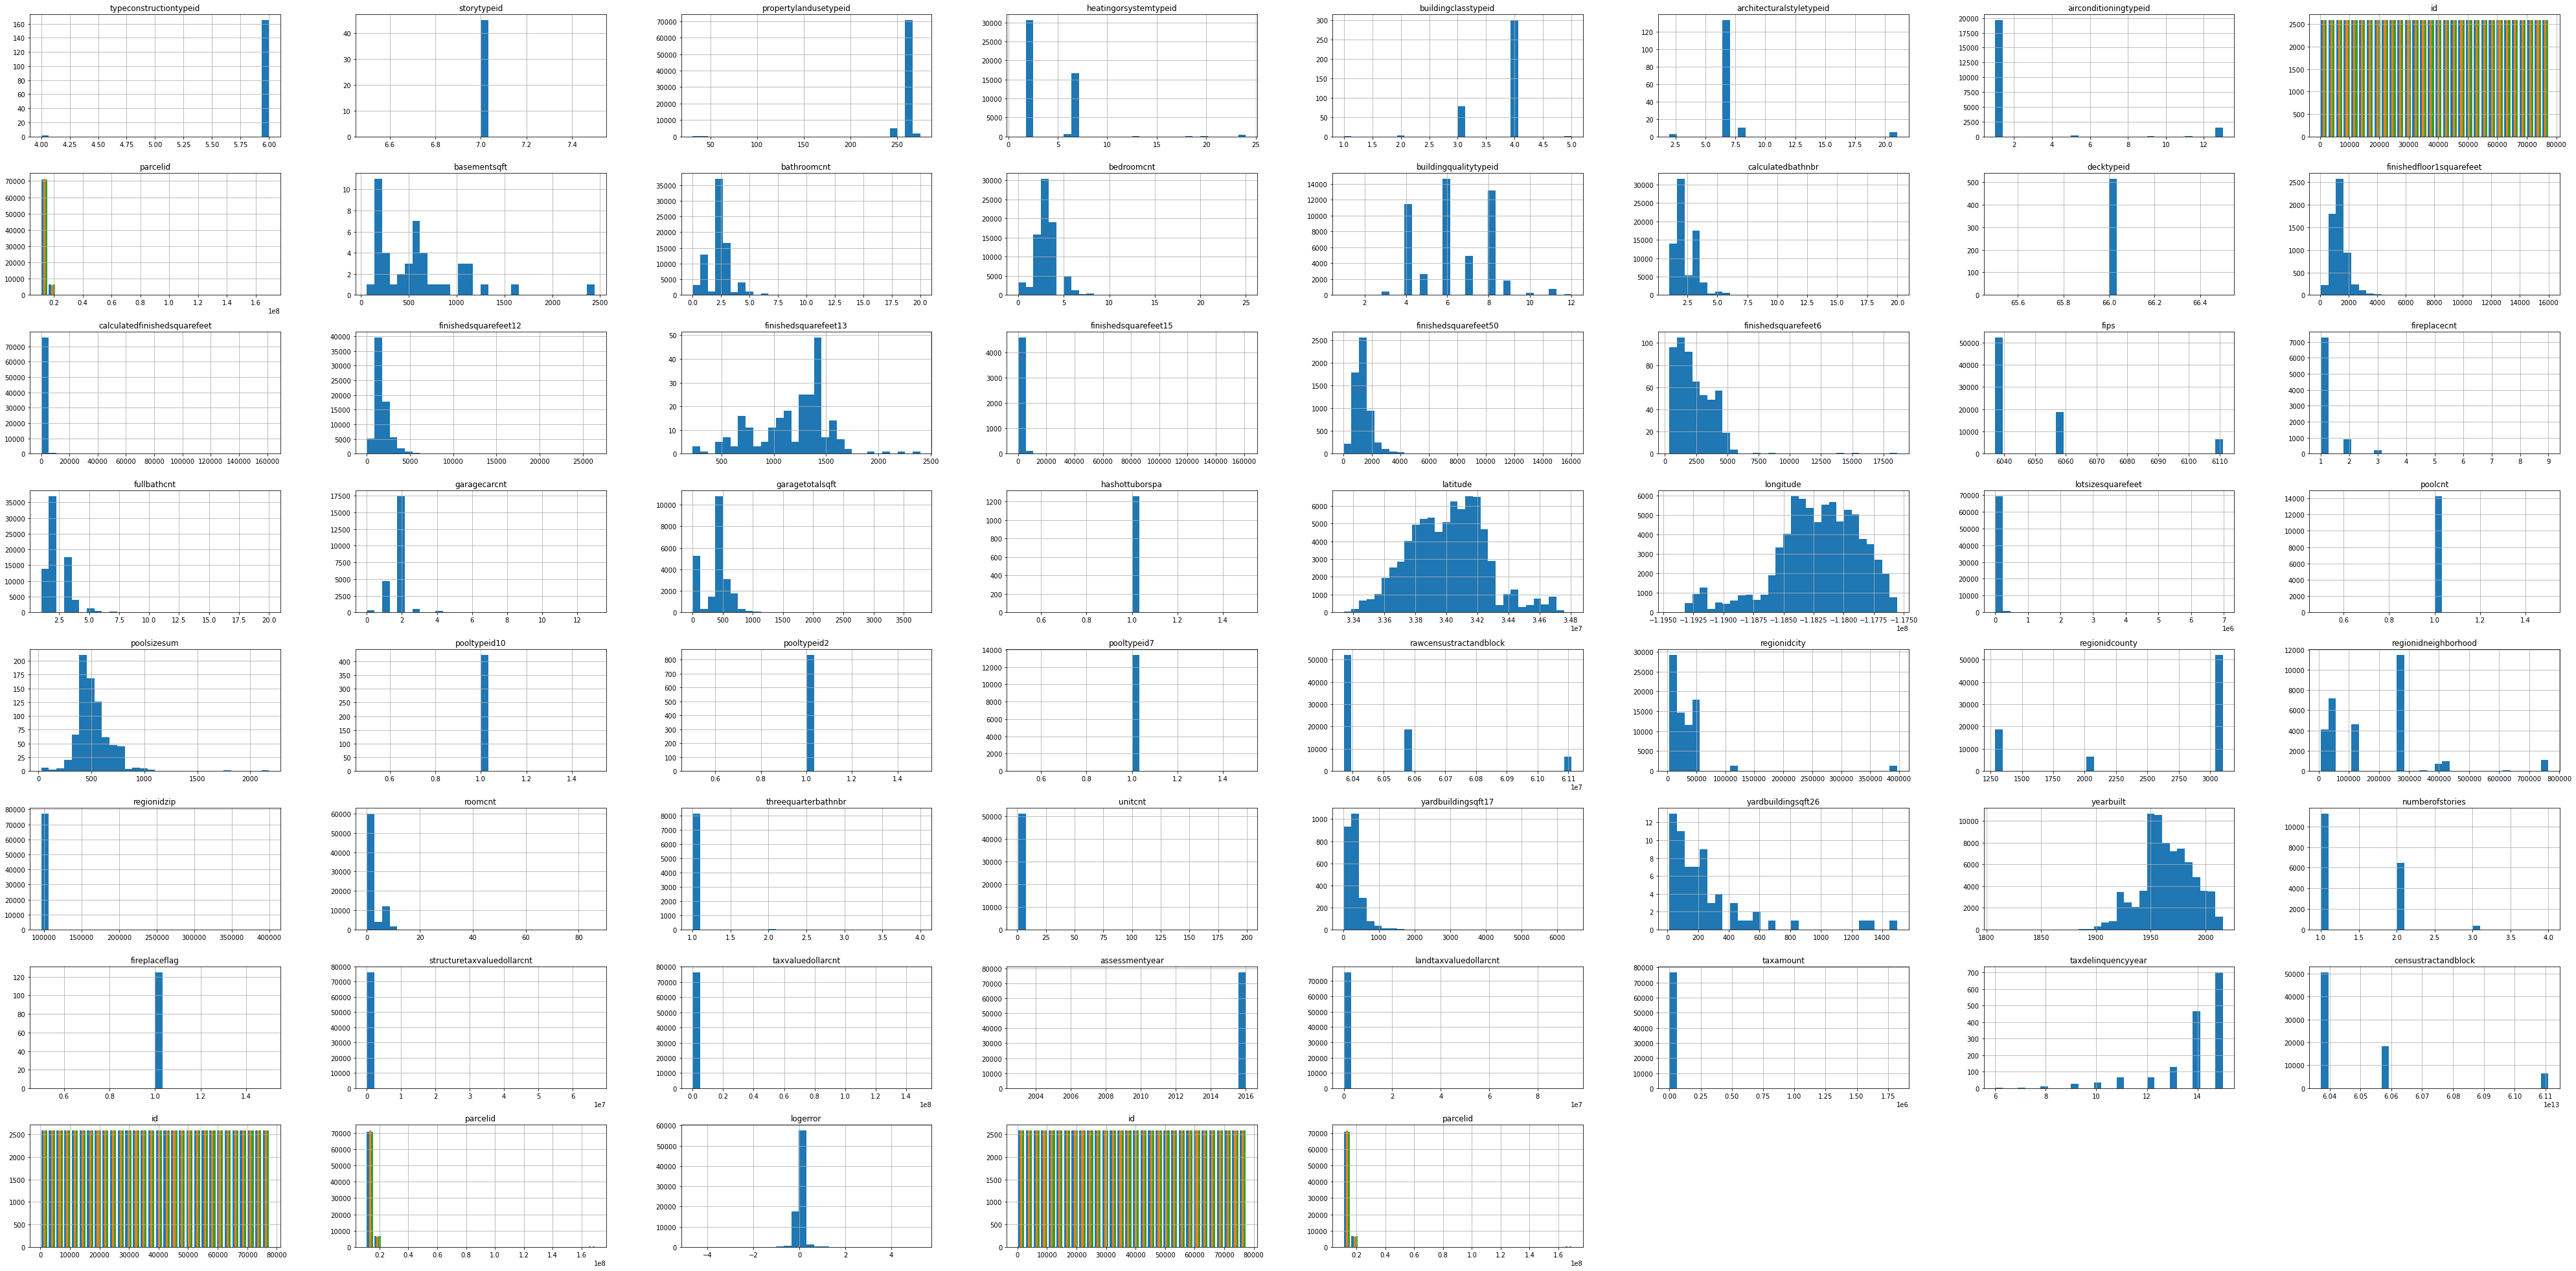

In [12]:
df.hist(figsize=(70, 35), bins=30)
plt.show()

** Takeaways **
bathroomcnt is normally distributed
bedroomcnt is normally distributed
cant tell much about the square feet, taxvaluedollarcnt, fips  by this hist
logerror looks pretty normally distributed with some outliers
latitude is right skewed
longitude is left skewed



In [13]:
#remove the columns listed above because we don't need these for analysis
df = wrangle_functions.remove_columns(df, cols_to_drop)

In [14]:
# how many null values are in the columns we chose to keep
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
bathroomcnt,0,0.00
bedroomcnt,0,0.00
calculatedfinishedsquarefeet,1112,1.43
fips,0,0.00
latitude,0,0.00
longitude,0,0.00
taxvaluedollarcnt,925,1.19
logerror,0,0.00
transactiondate,0,0.00
last_trans_date,0,0.00


In [15]:
# how should I handle the nulls in calculatedfinishedsquarefeet
df.calculatedfinishedsquarefeet.mean()

1834.9410080782202

In [16]:
#This is not doing what I want need to find anothe way to do it
# # Filling area column with mean of area column and home value with mean taxvaluedollarcnt
df.calculatedfinishedsquarefeet.fillna(df['calculatedfinishedsquarefeet'].mean(), inplace = True)
df.taxvaluedollarcnt.fillna(df['taxvaluedollarcnt'].mean(), inplace = True)

In [17]:
df.calculatedfinishedsquarefeet.value_counts()

 1,834.94    1112
 1,440.00     209
 1,344.00     190
 1,200.00     176
   960.00     171
             ... 
10,090.00       1
   465.00       1
 5,138.00       1
 4,424.00       1
 4,115.00       1
Name: calculatedfinishedsquarefeet, Length: 5111, dtype: int64

In [18]:
df.taxvaluedollarcnt.value_counts()

  440,745.23    925
  400,000.00     38
        9.00     38
  450,000.00     37
  390,000.00     35
               ... 
   70,225.00      1
   19,353.00      1
  172,664.00      1
  697,371.00      1
1,085,719.00      1
Name: taxvaluedollarcnt, Length: 55832, dtype: int64

In [19]:
# remove duplicates
df = df.loc[:,~df.columns.duplicated()]

In [20]:
col1 = df.taxvaluedollarcnt

In [21]:
#wrangle_functions.get_upper_outliers(df.taxvaluedollarcnt, k=1.5)
def outlier_function(df,cols, k):
	#function to detect and handle oulier using IQR rule
    for col in df[cols]:
        q1 = df.taxvaluedollarcnt.quantile(0.25)
        q3 = df.taxvaluedollarcnt.quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr
        df = df[(df[col] < upper_bound) & (df[col] > lower_bound)]
    return df

  

In [22]:
#outlier_function(df, col1, 1.5)

In [23]:
def train_validate_test_split(df):
    train_and_validate, test = train_test_split(df, train_size=0.8, random_state=123)
    train, validate = train_test_split(train_and_validate, train_size=0.75, random_state=123)
    return train, validate, test

In [24]:
train_validate_test_split(df)

(               bathroomcnt           bedroomcnt  calculatedfinishedsquarefeet  \
 71350                 3.00                 3.00                      2,758.00   
 62122                 1.00                 2.00                        566.00   
 77317                 3.00                 5.00                      2,494.00   
 29992                 0.00                 0.00                      1,206.00   
 21421                 2.00                 3.00                      1,200.00   
 ...                    ...                  ...                           ...   
 1487                  3.00                 3.00                      1,424.00   
 6500                  2.00                 3.00                      2,040.00   
 35307                 2.00                 2.00                      1,340.00   
 71838                 3.50                 5.00                      3,336.00   
 15375                 2.00                 2.00                      1,438.00   
 
              

In [25]:
train, validate, test = wrangle_functions.train_validate_test_split(df)

In [26]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,taxvaluedollarcnt,logerror,transactiondate,last_trans_date
71350,3.00,3.00,"2,758.00","6,059.00","33,874,361.00","-117,707,169.00","424,495.00",0.03,2017-08-29,2017-08-29
62122,1.00,2.00,566.00,"6,037.00","34,260,402.00","-118,417,134.00","41,289.00",0.02,2017-07-28,2017-07-28
77317,3.00,5.00,"2,494.00","6,037.00","34,277,733.00","-118,550,467.00","377,420.00",0.01,2017-09-18,2017-09-18
29992,0.00,0.00,"1,206.00","6,037.00","33,990,153.00","-117,881,843.00","440,745.23",-0.03,2017-04-26,2017-04-26
21421,2.00,3.00,"1,200.00","6,037.00","33,980,377.00","-118,295,397.00","236,178.00",0.00,2017-03-29,2017-03-29


In [27]:
####################### EXPLORE ##########################

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

A. Is there a difference in logerror between small and large houses?

B. Does logerror differ greatly by county?

C. Is there a dif. in logerror for cheap homes v. expensive?

D. Is there a relationship between logerror and latitude?

E. Is there a relationship between logerror and area?

F. Does logerror differ across fips?

2. Answer those questions through a mix of statistical tests and visualizations.

In [28]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,taxvaluedollarcnt,logerror,transactiondate,last_trans_date
71350,3.00,3.00,"2,758.00","6,059.00","33,874,361.00","-117,707,169.00","424,495.00",0.03,2017-08-29,2017-08-29
62122,1.00,2.00,566.00,"6,037.00","34,260,402.00","-118,417,134.00","41,289.00",0.02,2017-07-28,2017-07-28
77317,3.00,5.00,"2,494.00","6,037.00","34,277,733.00","-118,550,467.00","377,420.00",0.01,2017-09-18,2017-09-18
29992,0.00,0.00,"1,206.00","6,037.00","33,990,153.00","-117,881,843.00","440,745.23",-0.03,2017-04-26,2017-04-26
21421,2.00,3.00,"1,200.00","6,037.00","33,980,377.00","-118,295,397.00","236,178.00",0.00,2017-03-29,2017-03-29


In [72]:
train.shape

(46568, 15)

In [30]:
# split houses into "small" and "large" homes

In [31]:
df.calculatedfinishedsquarefeet.mean()

1834.9410080782209

In [32]:
# here I want to divide the homes at the mean for larger
train['large_home'] =train['calculatedfinishedsquarefeet']> 1834.94

In [33]:
# here I want to divide the homes at the mean for small homes
train['small_home'] =train['calculatedfinishedsquarefeet']< 1834.94

In [34]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,taxvaluedollarcnt,logerror,transactiondate,last_trans_date,large_home,small_home
71350,3.00,3.00,"2,758.00","6,059.00","33,874,361.00","-117,707,169.00","424,495.00",0.03,2017-08-29,2017-08-29,True,False
62122,1.00,2.00,566.00,"6,037.00","34,260,402.00","-118,417,134.00","41,289.00",0.02,2017-07-28,2017-07-28,False,True
77317,3.00,5.00,"2,494.00","6,037.00","34,277,733.00","-118,550,467.00","377,420.00",0.01,2017-09-18,2017-09-18,True,False
29992,0.00,0.00,"1,206.00","6,037.00","33,990,153.00","-117,881,843.00","440,745.23",-0.03,2017-04-26,2017-04-26,False,True
21421,2.00,3.00,"1,200.00","6,037.00","33,980,377.00","-118,295,397.00","236,178.00",0.00,2017-03-29,2017-03-29,False,True


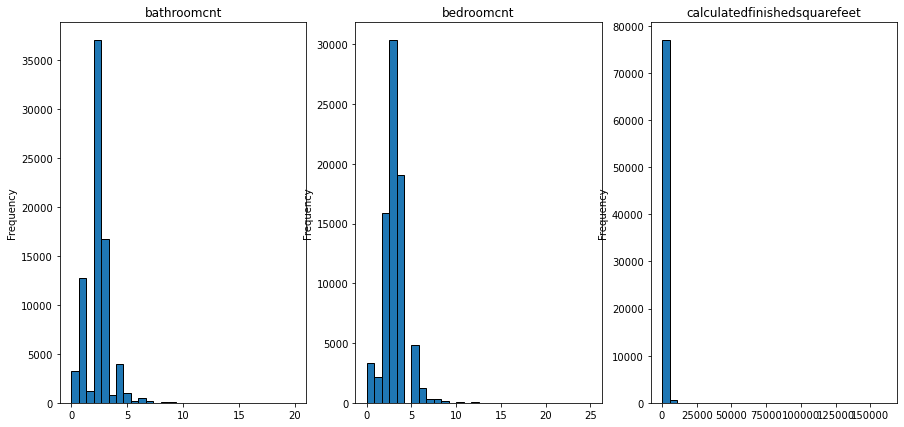

In [35]:
# First let's look at the distribution of each variable
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

for ax, col in zip(axs, train.select_dtypes('number')):
    df[col].plot.hist(ax=ax,bins=30, title=col, ec='black')

<AxesSubplot:>

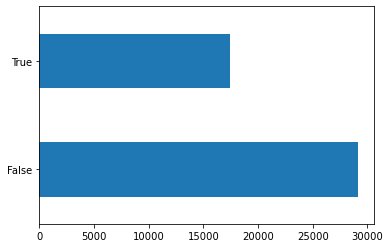

In [36]:
train.large_home.value_counts().plot.barh()

** Takeaways **
bathroom and bedroom count are both normally distributed
there are many more small homes than large

In [37]:
# need to check datatypes are correct
train.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
taxvaluedollarcnt               float64
logerror                        float64
transactiondate                  object
last_trans_date                  object
large_home                         bool
small_home                         bool
dtype: object

#A. Does logerror differ across home size small and large?
-Viz size against logerror
-Stats test to confirm

<AxesSubplot:xlabel='large_home', ylabel='logerror'>

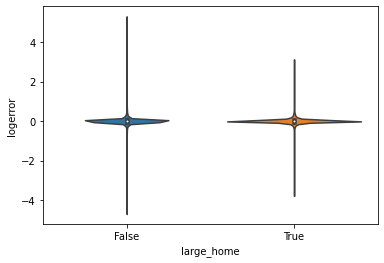

In [38]:
sns.violinplot(data=train, y='logerror', x='large_home')

In [39]:
# the violin chart seems to say yes there is more logerror for larger homes

Text(0.5, 1.0, 'Is there a difference in logerror for large homes?')

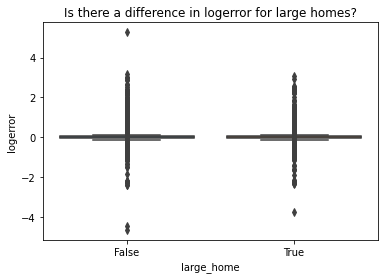

In [40]:
sns.boxplot(data=train, y='logerror', x='large_home')
plt.title("Is there a difference in logerror for large homes?")

In [41]:
# I can't answer that from this boxplot or the answer is ther is no noticeable dif.

<AxesSubplot:xlabel='large_home', ylabel='logerror'>

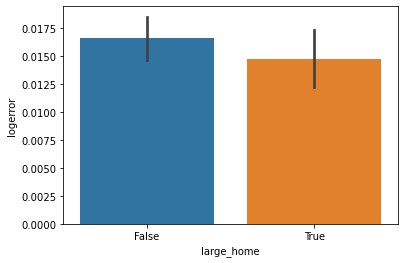

In [42]:
# make a barplot to visual dif 
sns.barplot(data=train, y='logerror', x='large_home')

In [43]:
# this bar plot seems to say there is tiny dif.

alpha= .05 

HO: There is no relationship between home size and logerror.

HA: There is a realtionship between home size and logerror.

In [44]:
# I am going to use a Pearson R test because I will compare two continuous values, logerror and area
test_results = stats.pearsonr(train.calculatedfinishedsquarefeet, train.logerror)

In [45]:
test_results

(0.0059462155171116455, 0.19944036567428708)

In [46]:
# the test statistic r at .0059 shows these two are NOT strongly correlated
# the p value above the alpha so we fail to reject the HO

** Takeaway
- There is no significant relationship between home size and logerror

<AxesSubplot:xlabel='logerror', ylabel='calculatedfinishedsquarefeet'>

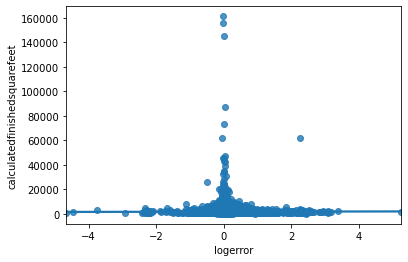

In [47]:
# use the function regplot to make a scatterplot
sns.regplot(x=df["logerror"], y=df["calculatedfinishedsquarefeet"])

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='logerror'>

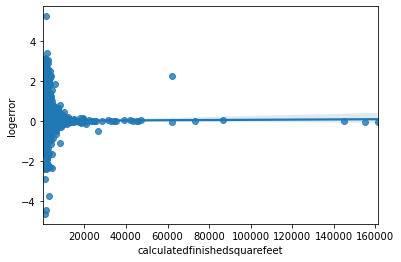

In [48]:
# use the function regplot to make a scatterplot
sns.regplot(x=df["calculatedfinishedsquarefeet"], y=df["logerror"])

In [49]:
# B. Is logerror differ greatly by county?
# 06111 = Ventura
# 6037 = Los Angeles
# 6059 = Orange

In [50]:
#find the 3 counties
train.fips.value_counts()

6,037.00    31359
6,059.00    11246
6,111.00     3963
Name: fips, dtype: int64

In [51]:
# make a column that converts each zipcode into the county name
train['county'] = train.fips.apply(lambda x: 'orange' if x == 6059.0 else 'los_angeles' if x == 6037.0 else 'ventura')

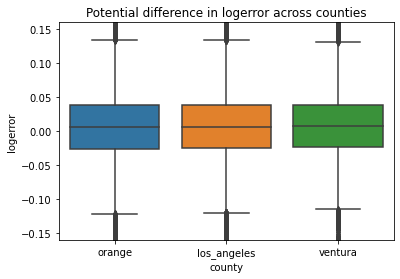

In [52]:
sns.boxplot(train.county, train.logerror)
plt.title('Potential difference in logerror across counties')
plt.ylim(-.16, .16)
plt.show()

In [53]:
# Test for equal variance:
# H0: variance in the logerror in Orange County and Los Angeles are equivalent
# alpha = 0.05
stats.levene(train[train.county == 'los_angeles'].logerror, train[train.county == 'orange'].logerror)

LeveneResult(statistic=0.9163937117851022, pvalue=0.3384290829603459)

In [ ]:
# variance is not equal

In [55]:
# H0: Mean logerror in Orange County is equivalent to mean logerror in Los Angeles County

In [54]:
stats.ttest_ind(train[train.county == 'los_angeles'].logerror, train[train.county == 'orange'].logerror, equal_var=False)

Ttest_indResult(statistic=0.724161174495654, pvalue=0.4689749338538822)

In [57]:
# Reject null hypothesis there is significant difference 
# between means of logerror between orange and Los Angeles Counties

** Takeaways
-logerror does differ significantly by county

C. Controlling for bedroom count, is there a relationship between logerror and longitude/latitude?

In [58]:
train['abs_logerr'] = train.logerror.apply(lambda x: x if x >= 0 else -x)

In [59]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,taxvaluedollarcnt,logerror,transactiondate,last_trans_date,large_home,small_home,county,abs_logerr
71350,3.00,3.00,"2,758.00","6,059.00","33,874,361.00","-117,707,169.00","424,495.00",0.03,2017-08-29,2017-08-29,True,False,orange,0.03
62122,1.00,2.00,566.00,"6,037.00","34,260,402.00","-118,417,134.00","41,289.00",0.02,2017-07-28,2017-07-28,False,True,los_angeles,0.02
77317,3.00,5.00,"2,494.00","6,037.00","34,277,733.00","-118,550,467.00","377,420.00",0.01,2017-09-18,2017-09-18,True,False,los_angeles,0.01
29992,0.00,0.00,"1,206.00","6,037.00","33,990,153.00","-117,881,843.00","440,745.23",-0.03,2017-04-26,2017-04-26,False,True,los_angeles,0.03
21421,2.00,3.00,"1,200.00","6,037.00","33,980,377.00","-118,295,397.00","236,178.00",0.00,2017-03-29,2017-03-29,False,True,los_angeles,0.00


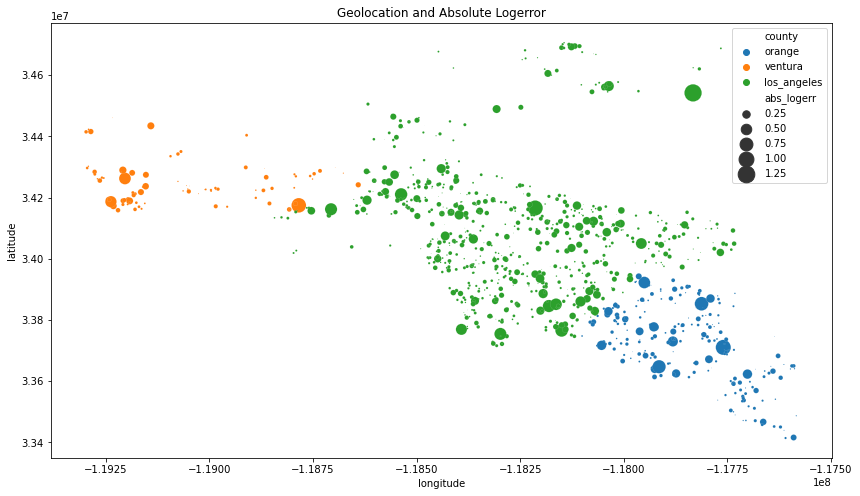

In [64]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='county', size='abs_logerr', sizes=(0,300), data=train.sample(1000))
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

In [61]:
train['bedroom_bin'] = pd.cut(train.bedroomcnt, [0,4,10])

In [65]:
train.bedroom_bin.value_counts()

(0, 4]     40498
(4, 10]     4092
Name: bedroom_bin, dtype: int64

In [62]:
train[train.bedroomcnt <= 4].shape

(42445, 15)

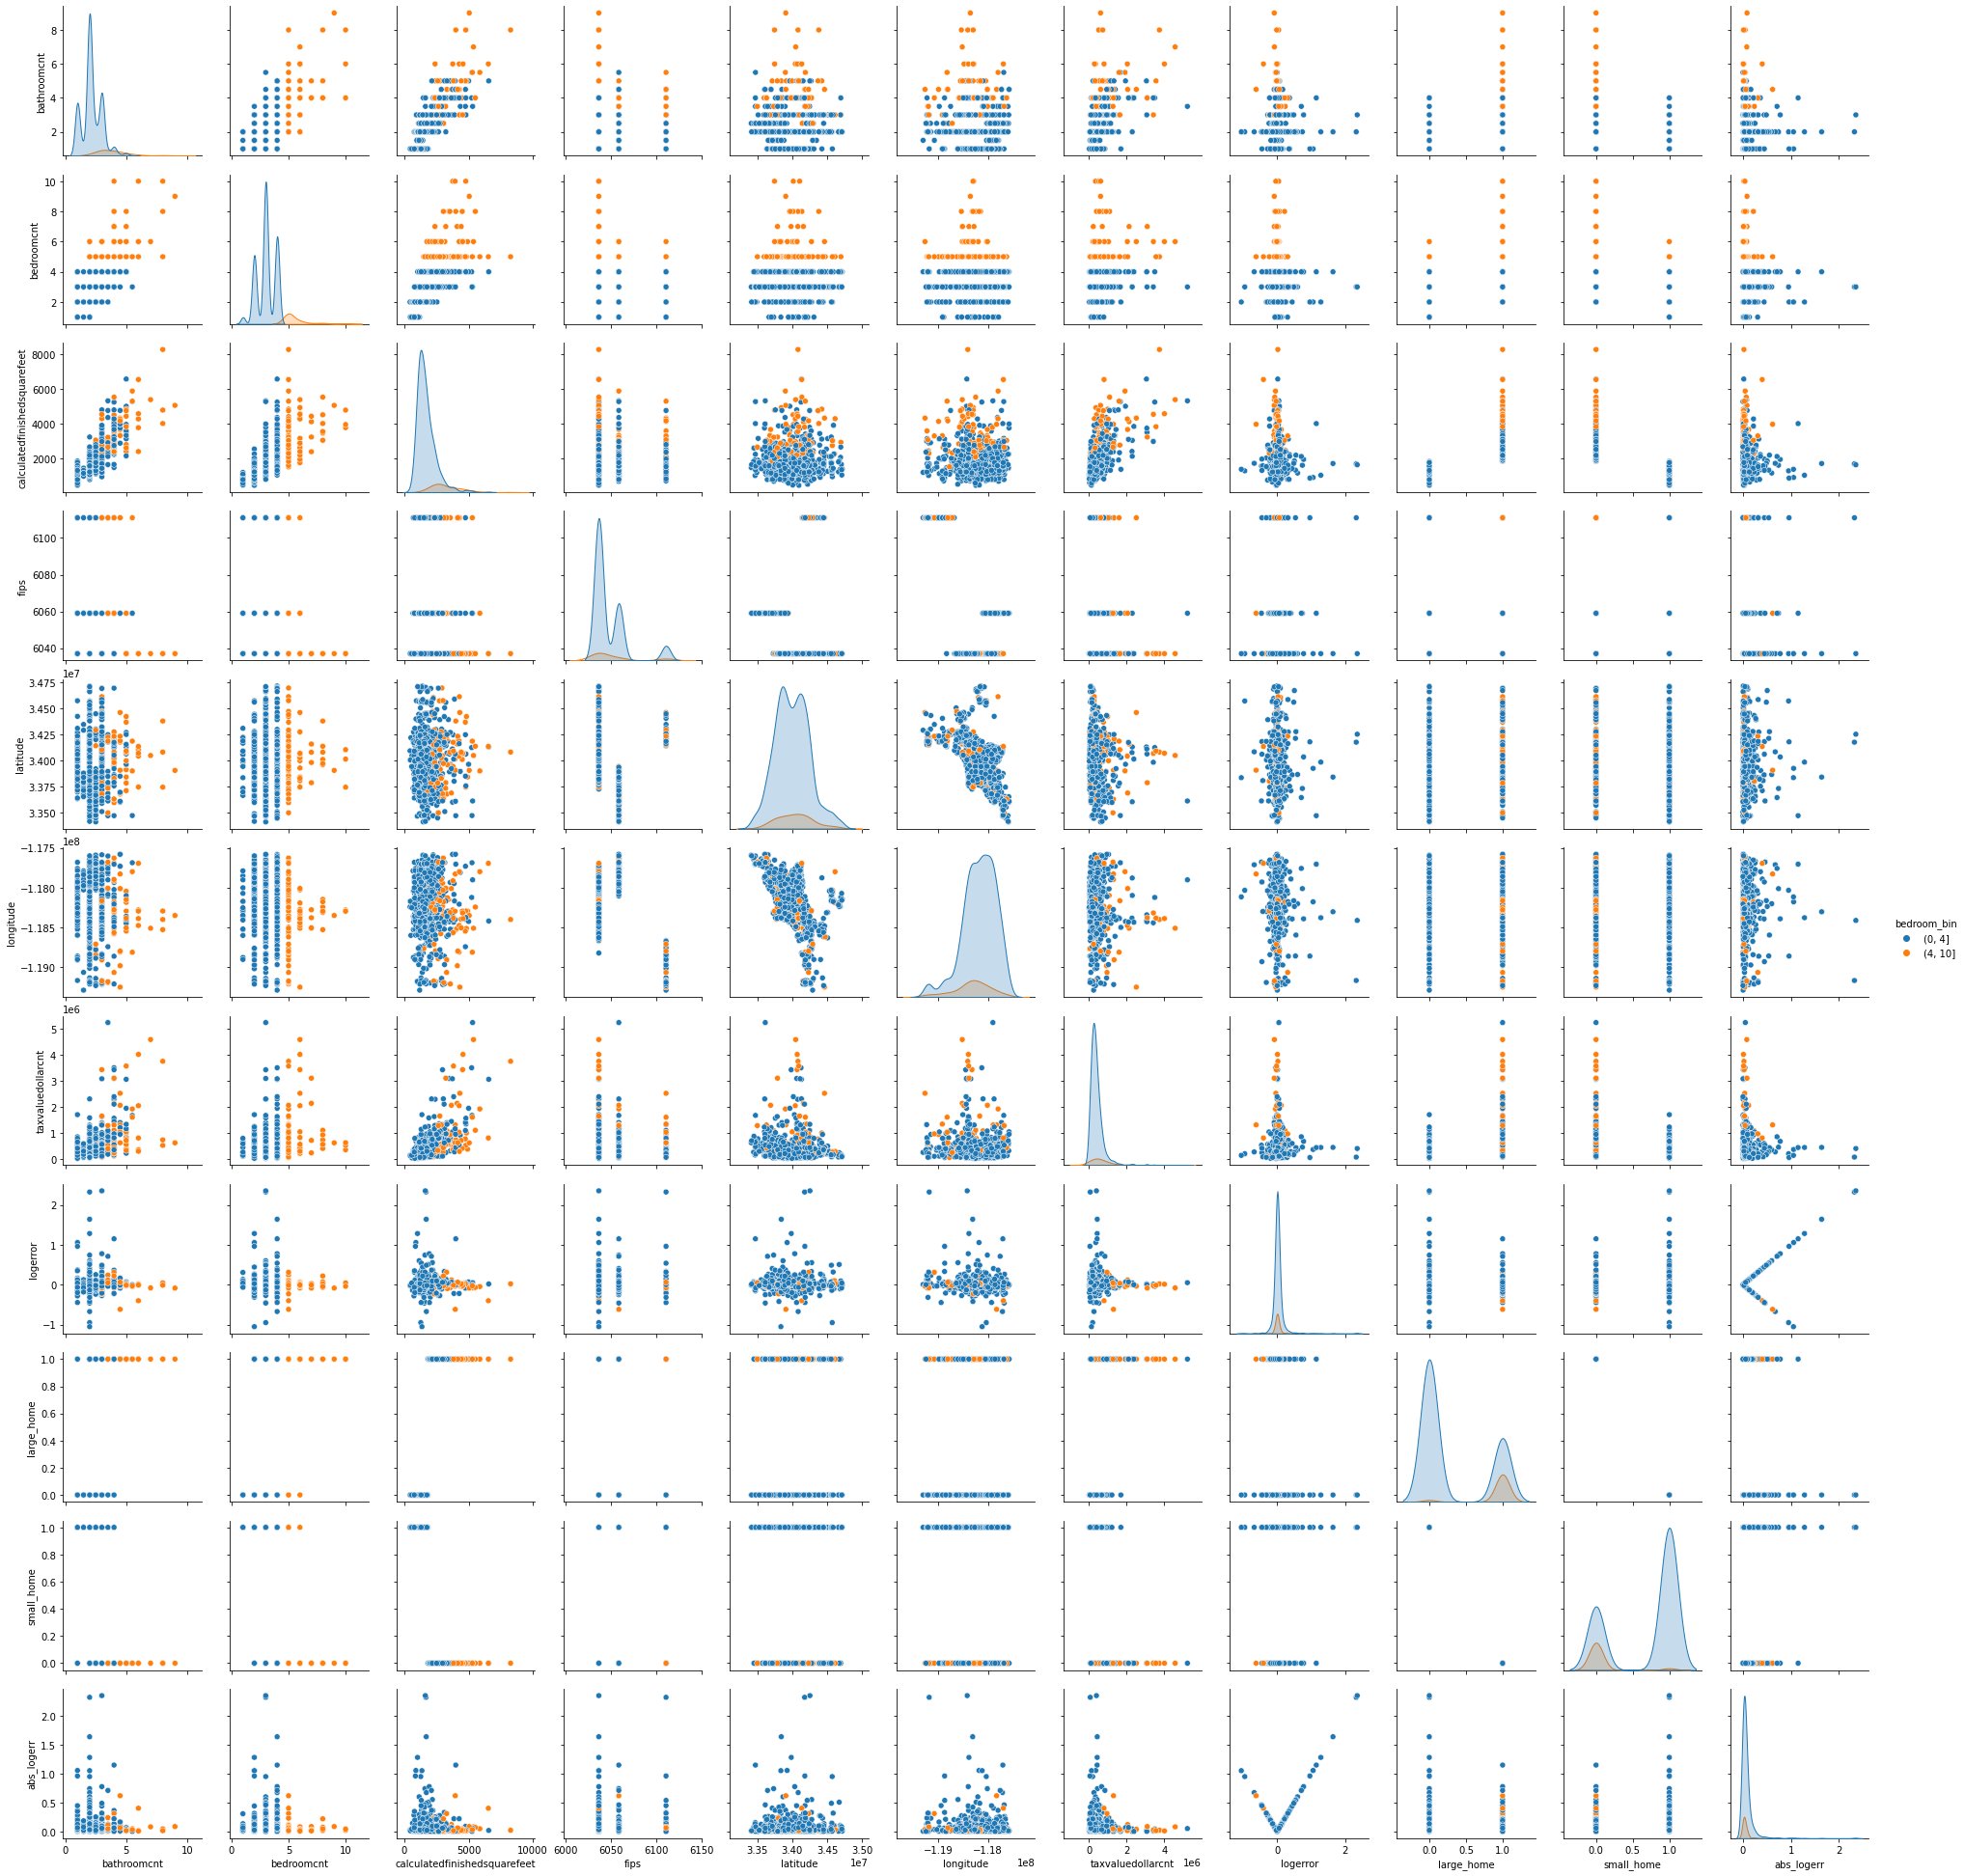

In [63]:
sns.pairplot(train.sample(1000), hue='bedroom_bin')

In [66]:
# C. Is there a relationship between longitude and logerror?

Relationship between Longitude and Logerror?


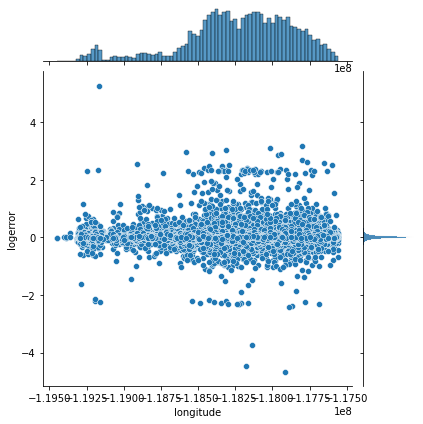

In [67]:
print('Relationship between Longitude and Logerror?')
sns.jointplot(x='longitude', y='logerror', data=train)
plt.xlabel('Longitude')
plt.ylabel('Logerror')
plt.show()

In [68]:
# D. Is there a relationship between bedroomcount and logerror?

Relationship between Bedroom count and Logerror?


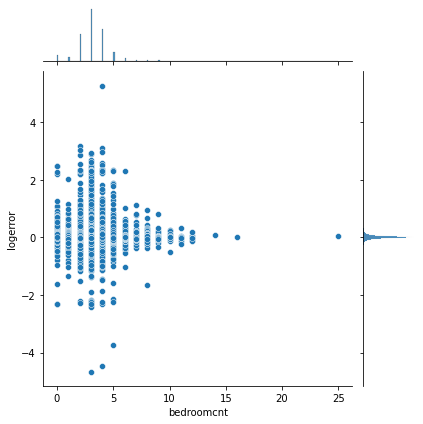

In [69]:
print('Relationship between Bedroom count and Logerror?')
sns.jointplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Logerror')
plt.show()

logerror is larger in homes with less than 5 bedrooms and decreases with homes with more than 5 bedrooms

In [ ]:
# H0: Variance in logerror for homes with 5 or less bedrooms is equivalent to those with
# more than 5 bedrooms
alpha of 0.05

In [70]:
# let's do a Levene's variance test between the two groups more than 5 beds and less than 5 beds
stats.levene(train[train.bedroomcnt > 5].logerror, train[train.bedroomcnt <= 5].logerror)

LeveneResult(statistic=0.7342550339911489, pvalue=0.39151184338949063)

p-value > .05, so we can say that the variances are not significantly different 
meaning equal variance is true
also must fail to reject HO assuming variance is true

E. Is there a relationship between latitude and logerror?

Relationship between Latitude and Logerror?


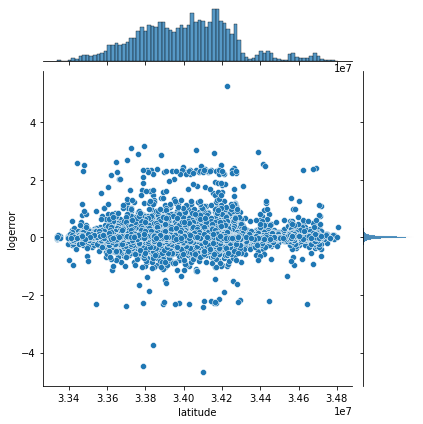

In [71]:
print('Relationship between Latitude and Logerror?')
sns.jointplot(x='latitude', y='logerror', data=train)
plt.xlabel('Latitude')
plt.ylabel('Logerror')
plt.show()